In [1]:
library("EpiEstim")
library("lubridate")
library("tidyverse")


Attaching package: ‘lubridate’


The following object is masked from ‘package:base’:

    date


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::as.difftime() masks base::as.difftime()
✖ lubridate::date()        masks base::date()
✖ dplyr::filter()          masks stats::filter()
✖ lubridate::intersect()   masks base::intersect()
✖ dplyr::lag()             masks stats::lag()
✖ lubridate::setdiff()     masks base::setdiff()
✖ lubridate::union()       masks base::union()



Aquí alisto factores, fechas y cambio el origen a local e importado como los necesita EpiEstim:

In [2]:
Mex <- read.csv("https://raw.githubusercontent.com/marianarf/covid19_mexico_analysis/master/covid_mex_20200401.csv")
Mex$Date_Confirmed <- mdy(as.character(Mex$Date_Confirmed))
Mex$Date_Symptoms <- mdy(as.character(Mex$Date_Symptoms))
Mex$Origin <- if_else(Mex$Origin=="Contacto","local","imported")
Mex$Origin <- as.factor(Mex$Origin)

Limpieza y Wrangling de los datos:

In [8]:
Mex_Clean_arriba50 <- Mex %>% 
  select(-c(Tested,Age,Sex,Inconsistent,Inconsistent_New_Date,Omission,
            Omission_Last_Date,Date_Arrival,Case_ID)) %>% 
  group_by(Region,Date_Symptoms,Origin) %>% 
  summarise(casos = n())  %>% 
  ungroup() %>% 
  group_by(Region,Origin) %>% 
  mutate(acumulado = cumsum(casos))%>% 
  ungroup() %>% 
  group_by(Region) %>% 
  mutate(max = sum(casos)) %>% 
  filter(max > 50) %>% 
  select(-c(max,casos)) %>% 
  ungroup() %>% 
  rename(Estado = Region, 
         dates = Date_Symptoms, 
         Origen = Origin, 
         Incidencia = acumulado)

In [9]:
head(Mex_Clean_arriba50)

Estado,dates,Origen,Incidencia
<fct>,<date>,<fct>,<int>
CIUDAD DE MÉXICO,2020-02-17,local,1
CIUDAD DE MÉXICO,2020-02-22,imported,1
CIUDAD DE MÉXICO,2020-02-23,imported,2
CIUDAD DE MÉXICO,2020-02-29,imported,3
CIUDAD DE MÉXICO,2020-03-01,imported,4
CIUDAD DE MÉXICO,2020-03-02,imported,5


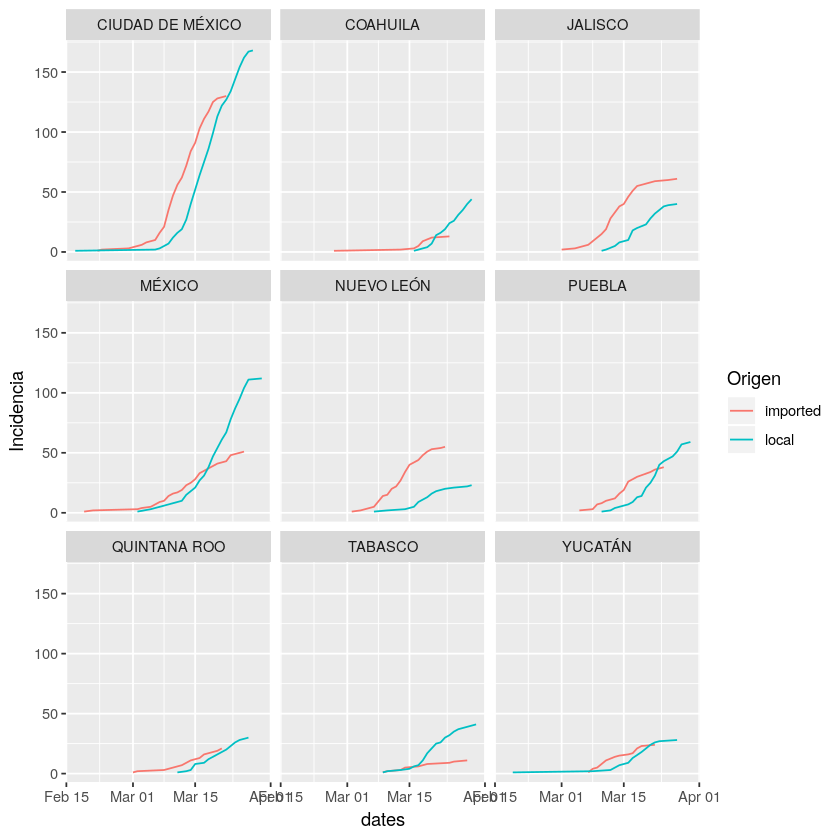

In [11]:
Mex_Clean_arriba50 %>% 
  ggplot(aes(x=dates,y=Incidencia,color=Origen))+geom_line()+facet_wrap(~Estado)
                                                                         
# Los outputs gráficos de R en jupyter siempre son horribles.                                                                        

Configuración del **SERIAL INTERVAL** según la referencia que paso lalito:

In [12]:
config <- make_config(list(mean_si = 4.7, std_mean_si = 0.5,
                           min_mean_si = 3.4, max_mean_si = 6.0,
                           std_si = 2.9, std_std_si = 0.6,
                           min_std_si = 1.9, max_std_si = 3.9))

Corrida como ejemplo de JALISCO:

In [14]:
Mex_Clean_arriba50 %>% 
  spread(Origen,Incidencia) %>% 
  filter(Estado == "JALISCO") %>% 
  select(c(dates,local,imported)) %>% 
  ungroup() %>%
  mutate(local = replace_na(local, 0)) %>% 
  mutate(imported = replace_na(imported, 0)) %>% 
  estimate_R(.,method = "uncertain_si", config = config)

# EL error habla si no mal entiendo de que necesita saltos diarios y el acumulado no cumple con eso... 
# sugerencias?

Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

Warning message in if (unique(diff(dates)) != 1) {:
“the condition has length > 1 and only the first element will be used”


ERROR: Error in check_dates(incid): incid$dates must contain dates which are all in a row.
